In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
pwd = os.getcwd()
file201501 = os.path.join(pwd, '2015', 'kody nowe01,15.xls')

#A TRICK TTO NOT GET 5.1 IN COLS NAMES
cols = pd.read_excel(file201501, header=None, nrows=1).values[0]
df201501 = pd.read_excel(file201501, header=None, skiprows=1)
df201501.columns = cols

column_names = list(df201501.columns)
print(column_names)

[nan, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 5, 6, 12, 13, 19, 20, 26, 27, 28, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'SUMA', nan, 'CENA NETTO']


##### wyciagniecie nazw i sum sprzedaży mięsa i wędlin

In [96]:
column = ['SUMA']
summary_df = pd.DataFrame(df201501.iloc[0:50, 41])
change = list(summary_df.columns)
change[0] = 'TOWAR'
summary_df.columns = change
summary_df = summary_df.merge(df201501.loc[0:49, column], left_index=True, right_index=True)
summary_df.head()

,TOWAR,SUMA
0,1. SCHAB Z KOŚCIĄ,181.920
1,2. SCHAB BEZ KOŚCI,192.732
2,3. KARCZEK BEZ KOŚCI,156.977
3,4. SZYNKA Z KOŚCIA,0.000
4,5. SZYNKA BEZ KOŚCI,177.450


##### TABELA ZE SPRZEDAZA Z POSZCZEGLNYCH DNI

In [102]:
data_date = "01-2015"

sprzedaz = pd.DataFrame(df201501.iloc[0:50, 38])
change1 = list(sprzedaz.columns)
change1[0] = 'TOWAR'
sprzedaz.columns = change

sprzedaz = sprzedaz.merge(pd.DataFrame(df201501.iloc[0:50, 1:29]), left_index=True, right_index=True)
sprzedaz.head()


,TOWAR,3,4,5,6,7,10,11,12,13,...,27,5,6,12,13,19,20,26,27,28
0,1. SCHAB Z KOŚCIĄ,1.978,7.48,3.64,3.31,15.33,10.49,13.71,4.36,0.00,...,0.00,8.10,7.45,8.56,4.70,6.570,1.59,7.74,4.94,16.17
1,2. SCHAB BEZ KOŚCI,5.200,10.56,3.79,1.02,6.2,7.57,6.00,2.92,1.45,...,0.72,6.10,4.60,9.26,36.15,8.732,1.59,3.44,3.56,15.87
2,3. KARCZEK BEZ KOŚCI,6.110,2.34,3.65,0.70,6.57,8.45,8.90,0.00,3.98,...,0.96,6.35,8.10,3.10,7.65,2.610,2.10,4.71,5.29,15.69
3,4. SZYNKA Z KOŚCIA,0.000,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.00,0.00
4,5. SZYNKA BEZ KOŚCI,3.020,65.10,0.00,2.10,15.1,8.31,7.58,2.74,1.02,...,0.00,2.58,1.07,7.07,3.55,2.680,1.18,8.12,1.13,7.30


#### FUNCKJA SUMUJACA ZDUBLOWANE KOLUMNY CZYLI KILKA KAS FISKALNYCH JEDNEGO DNIA

In [98]:
def sumuj_kasy(df) -> pd.DataFrame:
    hist_kolumn = df.columns.value_counts()
    zduplikowane_kolumny = hist_kolumn[hist_kolumn > 1].index.tolist()
    print(zduplikowane_kolumny)
    df_with_deleted_duplicate_columns = df.drop(columns = [int(col) for col in zduplikowane_kolumny])
    
    for col_name in zduplikowane_kolumny:
        indexes = [i for i, col in enumerate(df.columns) if col == col_name]
        
        dup_col1 = df.iloc[:, indexes[0]]
        dup_col2 = df.iloc[:, indexes[1]]
        dup_col1 = dup_col1.add(dup_col2)
        
        df_with_deleted_duplicate_columns[col_name] = dup_col1
            
    return df_with_deleted_duplicate_columns

##### modelowanie df sprzedaz, przygotowanie na wykres, sort kolumn i strip nazw produktow

In [108]:
def clean_products_names(series):
    def clean_record(record):
        new = ''.join([sign for sign in record if sign != '.' and not sign.isdigit()])
        return new.lstrip()
    return series.apply(clean_record)

In [109]:
sprzedaz1 = sprzedaz.copy()

col_poducts = clean_products_names(sprzedaz1['TOWAR'])

sprzedaz_zsumowane_kasy = sumuj_kasy(sprzedaz1)

tmp = sprzedaz_zsumowane_kasy.drop(columns={'TOWAR'})
sprzedaz_zsumowane_kasy1 = tmp.sort_index(axis=1)

#sprzedaz_zsumowane_kasy1['TOWAR'] = col_poducts

sprzedaz_zsumowane_kasy1 #TOWAR MA INDEX 20


[19, 27, 5, 6, 26, 12, 13, 20]


,3,4,5,6,7,10,11,12,13,14,17,18,19,20,21,24,25,26,27,28
0,1.978,7.48,11.740,10.76,15.33,10.490,13.71,12.92,4.70,15.13,5.23,6.900,6.570,3.540,19.750,0.000,6.450,10.110,4.94,16.170
1,5.200,10.56,9.890,5.62,6.2,7.570,6.00,12.18,37.60,8.22,3.48,1.920,9.102,3.220,22.710,20.240,3.300,4.770,4.28,15.870
2,6.110,2.34,10.000,8.80,6.57,8.450,8.90,3.10,11.63,12.62,4.91,2.760,3.500,5.260,22.324,11.220,5.480,7.173,6.25,15.690
3,0.000,0.00,0.000,0.00,0,0.000,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
4,3.020,65.10,2.580,3.17,15.1,8.310,7.58,9.81,4.57,3.10,3.52,5.730,4.830,1.180,9.210,5.060,12.050,8.120,1.13,7.300
5,14.280,13.18,15.350,7.27,17.1,22.630,13.10,24.27,11.81,15.65,15.39,9.480,11.220,9.150,16.630,10.150,17.430,15.230,10.55,25.390
6,4.850,3.10,6.810,8.49,19.93,10.290,3.47,2.53,8.93,8.70,0.67,1.920,7.100,6.000,14.660,9.030,16.720,8.740,13.71,6.770
7,6.690,23.22,22.380,7.62,10.76,7.860,29.74,14.22,4.48,10.96,3.82,8.630,14.920,8.630,13.860,7.120,15.350,26.940,5.57,8.200
8,7.020,28.81,13.690,18.27,17.96,19.520,19.97,9.12,15.60,3.42,0.00,7.780,9.060,14.090,9.430,14.400,15.610,4.790,11.10,17.570
9,3.980,7.39,20.360,6.31,15.83,10.000,26.19,28.82,19.35,10.88,10.50,6.540,7.890,17.460,26.100,11.740,15.650,18.860,22.36,15.460


#### Pierwsza proba zrobienai wykresu jakiegos

TypeError: 'Index' object is not callable

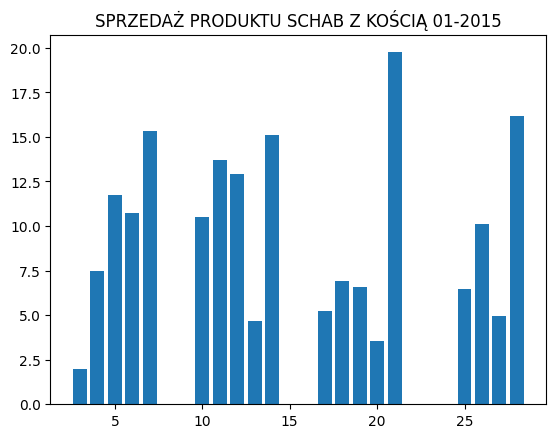

In [124]:


x = sprzedaz_zsumowane_kasy1.columns
y = sprzedaz_zsumowane_kasy1.iloc[0].values

#plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.title("SPRZEDAŻ PRODUKTU " + col_poducts[0] + " " + data_date)

plt.xticks()

plt.show()